# Soft Sorting

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
!pip install -q torchvision

In [2]:
import collections
import functools
import io
import urllib
from typing import Any

from tqdm.notebook import tqdm

import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
import torchvision
from flax import struct
from scipy import ndimage
from torch.utils import data

import matplotlib.pyplot as plt

from ott.tools import soft_sort

## Sorting operators

Given an array of $n$ numbers, several operators arise around the idea of sorting:

- The soft {func}`~ott.tools.soft_sort.sort` operator reshuffles the values in order, from smallest to largest.
- The soft {func}`~ott.tools.soft_sort.ranks` operator associates to each value its rank, when sorting in ascending order.
- The soft {func}`~ott.tools.soft_sort.quantile` operator consider a `level` value between 0 and 1, to return the element of the sorted array indexed at `int(n * level)`, the median for instance if that level is set to $0.5$.
- The `top-k` operator is equivalent to the {func}`~ott.tools.soft_sort.sort` operator, but only returns the
largest $k$ values, namely the last $k$ values of the sorted vector.

Here are some examples

In [3]:
x = jnp.array([1.0, 5.0, 4.0, 8.0, 12.0])
jnp.sort(x)

DeviceArray([ 1.,  4.,  5.,  8., 12.], dtype=float32)

In [4]:
x.device()

StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)

In [5]:
def rank(x):
    return jnp.argsort(jnp.argsort(x))


rank(x)

DeviceArray([0, 2, 1, 3, 4], dtype=int32)

In [6]:
jnp.quantile(x, 0.5)

DeviceArray(5., dtype=float32)

## Soft operators

Sorting operators are ubiquitous in CS and stats, but have several limitations when used in modern deep learning architectures. For instance, `ranks` is integer valued: if used at some point within a DL pipeline, one won't be able to differentiate through that step because the gradient of these integer values does not exist, or is ill-defined. Indeed, the vector of `ranks` of a slightly perturbed vector $x+\Delta x$ is the same as that for $x$, or switches ranks at some indices when inversions occur. Practially speaking, any loss or intermediary operation based on `ranks` will break backpropagation.

This colab shows how *soft* counterparts to these operators are defined in OTT. By *soft*, we mean **differentiable**, **approximate** proxies to these original _"hard"_ operators. For instance, soft {func}`~ott.tools.soft_sort.ranks` returned by OTT operators won't be integer valued, but instead floating point approximations; soft {func}`~ott.tools.soft_sort.sort` will not contain exactly the $n$ values contained in the input array, reordered, but instead $n$ combinations of thoses values that look very close to them.

**These soft operators trade off accuracy for a more informative Jacobian**. This trade-off is controlled by a non-negative parameter `epsilon`: The *smaller* `epsilon`, the closer to the original ranking and sorting operations; The *bigger*, the more bias yet the more informative gradients. That `epsilon` also correponds to that used in regularized OT, see {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` documentation for more.

The behavior of these operators is illustrated below.

### Soft sort

In [7]:
softsort_jitted = jax.jit(soft_sort.sort)
print(softsort_jitted(x))

[ 1.0504104  4.1228743  4.8620267  8.006994  11.957704 ]


As we can see, the values are close to the original ones but not exactly equal. Here, `epsilon` is set by default to `1e-2`. A smaller `epsilon` reduces that gap, whereas a bigger one would tend to squash all returned values to the **average** of the input values.

In [8]:
print(softsort_jitted(x, epsilon=1e-4))
print(softsort_jitted(x, epsilon=1e-1))

[ 0.9983629  3.994969   5.006686   8.010008  11.989864 ]
[ 2.5705485  3.733634   5.462019   8.000692  10.233107 ]


### Soft top-k

The soft operators we propose build on a common idea: formulate sorting operations as optimal transports from an array of $n$ values to a predefined target measure of $m$ points. The user is free to choose $m$, providing great flexibility depending on the use case. 

Transporting an input discrete measure of $n$ points towards one of $m$ points results in a $O(nm)$ complexity. The bigger $m$, the more fine grained quantities we recover. For instance, if we wish to get both a fine grained yet differentiable sorted vector, or vector of ranks, one can define a target measure of size $m=n$, leading to a $O(n^2)$ complexity.

On the contrary, if we are only interested in singling out a few important ranks, such as when considering `top-k` values, we can simply transport the inputs points onto $k+1$ targets, leading to a smaller complexity in $O(nk)$. When $k \ll n$, the gain in time and memory can be of course substantial.

Here is an example.

In [9]:
top5 = jax.jit(functools.partial(soft_sort.sort, topk=5))

# Generates a vector of size 1000
big_x = jax.random.uniform(jax.random.PRNGKey(0), (1000,))
top5(big_x)

DeviceArray([0.9506124 , 0.97415835, 0.9832732 , 0.98791456, 0.9905736 ],            dtype=float32)

### Soft Ranks

Similarly, we can compute soft {func}`~ott.tools.soft_sort.ranks`, which do not output integer values, but provide instead a differentiable, float valued, approximation of the vector of ranks.

In [10]:
softranks = jax.jit(soft_sort.ranks)
print(softranks(x))

[0.01550213 1.8387042  1.148726   2.9977007  3.9927652 ]


### Regularization effect

As mentioned earlier, `epsilon` controls the tradeoff between accuracy and differentiability. Larger `epsilon` tend to merge the soft {func}`~ott.tools.soft_sort.ranks` of values that are close, up to the point where they all collapse to the average rank or average value.

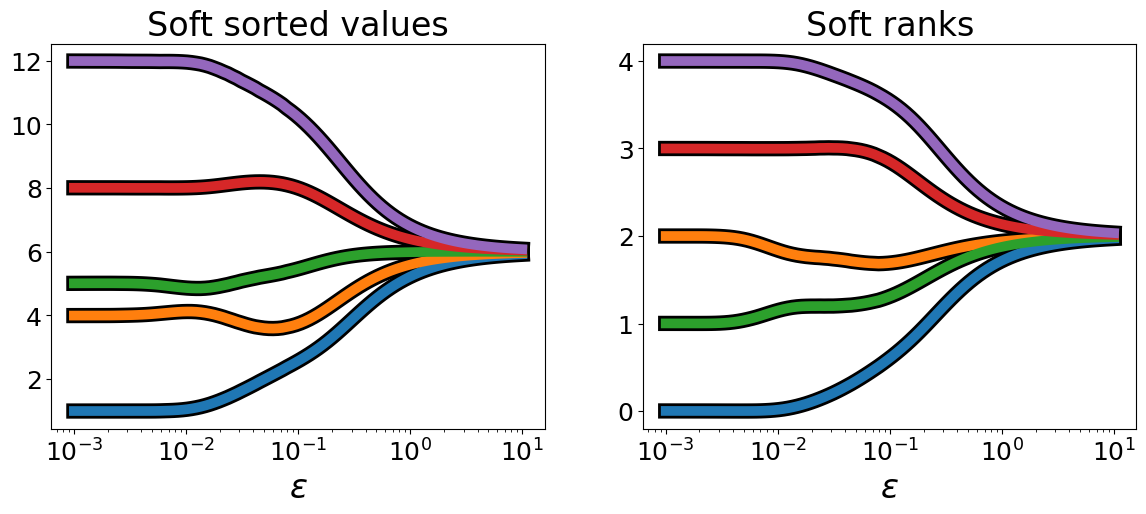

In [11]:
epsilons = np.logspace(-3, 1, 100)
sorted_values = []
ranks = []
for e in epsilons:
    sorted_values.append(softsort_jitted(x, epsilon=e))
    ranks.append(softranks(x, epsilon=e))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for values, ax, title in zip(
    (sorted_values, ranks), axes, ("sorted values", "ranks")
):
    ax.plot(epsilons, np.array(values), color="k", lw=11)
    ax.plot(epsilons, np.array(values), lw=7)
    ax.set_xlabel(r"$\epsilon$", fontsize=24)
    ax.tick_params(axis="both", which="both", labelsize=18)
    ax.set_title(f"Soft {title}", fontsize=24)
    ax.set_xscale("log")

Note how none of the lines above cross. This is a fundamental property of {func}`~ott.tools.soft_sort.sort` operators, proved in {cite}`cuturi:19`: soft sorting and ranking operators are monotonic: the vector of soft-sorted values will remain increasing for any `epsilon`, whereas if an input value $x_i$ has a smaller (hard) rank than $x_j$, its soft-rank, for any value of `epsilon`, will also remain smaller than that for $x_j$.

### Soft quantile

To illustrate further the flexibility provided by setting target measures, one can notice that when a soft {func}`~ott.tools.soft_sort.quantile` is targeted (for instance the soft median), the complexity becomes simply $O(n)$. This is illustrated below to define "soft median" differentiable filter on a noisy image.

In [12]:
softquantile = jax.jit(soft_sort.quantile)
softquantile(x, level=0.5)

DeviceArray([4.995721], dtype=float32)

In [13]:
url = "https://raw.githubusercontent.com/matplotlib/matplotlib/master/doc/_static/stinkbug.png"
with urllib.request.urlopen(url) as resp:
    image = plt.imread(io.BytesIO(resp.read()))
image = image[..., 0]

In [14]:
def salt_and_pepper(im: np.array, amount: float = 0.05):
    result = np.copy(im)
    result = np.reshape(result, (-1,))
    num_noises = int(np.ceil(amount * im.size))
    indices = np.random.randint(0, im.size, num_noises)
    values = np.random.uniform(size=(num_noises,)) > 0.5
    result[indices] = values
    return np.reshape(result, im.shape)


noisy_image = salt_and_pepper(image, amount=0.1)

The {func}`~scipy.ndimage.generic_filter` from scipy does not run well on GPUs thus we force CPU execution for the following computations.

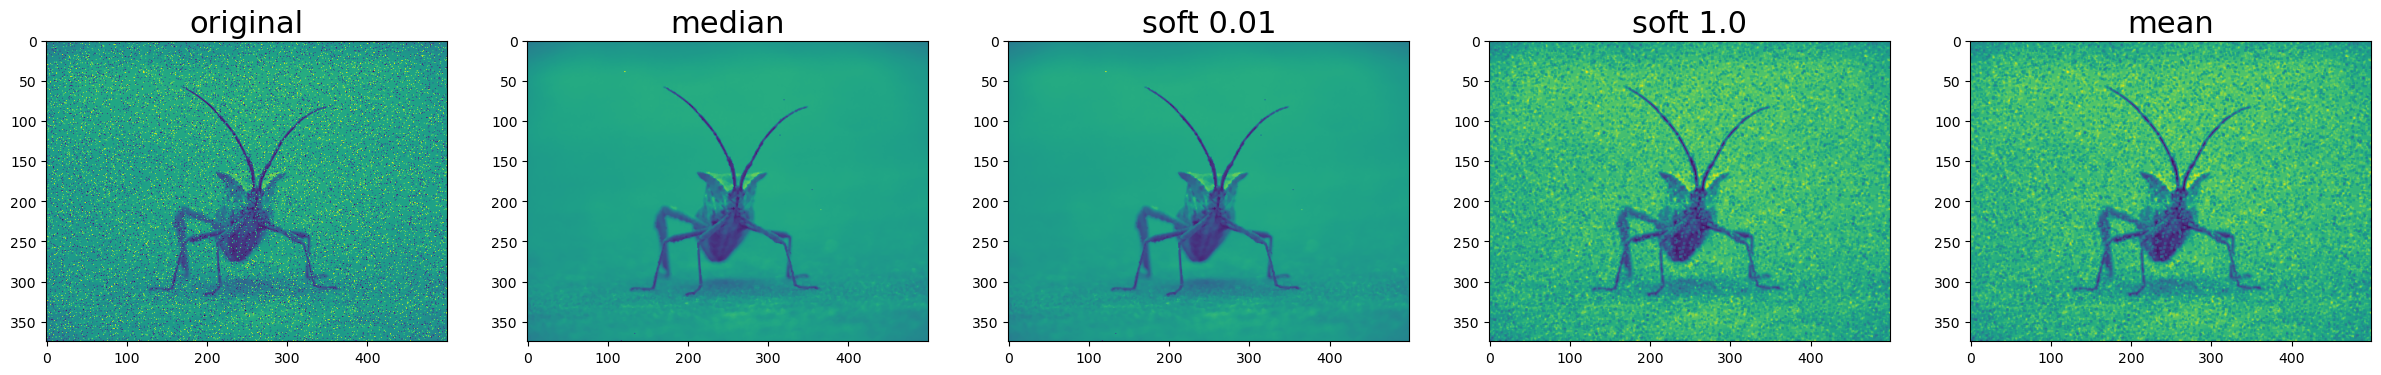

In [15]:
with jax.default_device(jax.devices("cpu")[0]):
    softmedian = functools.partial(soft_sort.quantile, level=0.5)

    fns = {"original": None, "median": np.median}
    for e in [0.01, 1.0]:
        fns[f"soft {e}"] = jax.jit(functools.partial(softmedian, epsilon=e))
    fns.update(mean=np.mean)

    fig, axes = plt.subplots(1, len(fns), figsize=(len(fns) * 6, 4))
    for key, ax in zip(fns, axes):
        fn = fns[key]
        soft_denoised = (
            ndimage.generic_filter(
                jnp.array(noisy_image), fn, footprint=jnp.ones((3, 3))
            )
            if fn is not None
            else noisy_image
        )
        ax.imshow(soft_denoised)
        ax.set_title(key, fontsize=22)

## Learning through a soft ranks operator.

A crucial feature of OTT lies in the ability it provides to **differentiate** seamlessly through any quantities that follow an optimal transport computation, making it very easy for end-users to plug them directly into end-to-end differentiable architectures. 

In this tutorial we show how OTT can be used to implement a loss based on soft {func}`~ott.tools.soft_sort.ranks`. That soft 0-1 loss is used here to train a neural network for image classification, as done by {cite}`cuturi:19`.

This implementation relies on [Flax](https://github.com/google/flax) and [Optax](https://github.com/deepmind/optax) libraries for creating and training neural networks with JAX. We also use [PyTorch](https://pytorch.org) dataset and dataloaders.

### Model

We will train a vanilla CNN, in order to classify images from the MNIST dataset.

In [16]:
class ConvBlock(nn.Module):
    """A simple CNN block."""

    features: int = 32
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = nn.Conv(features=self.features, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.Conv(features=self.features, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x


class CNN(nn.Module):
    """A simple CNN model."""

    num_classes: int = 10
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = ConvBlock(features=32)(x)
        x = ConvBlock(features=64)(x)
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)
        return x

### Losses & Metrics

The $0/1$ loss of a classifier on a labeled example is $0$ if the logit of the true class ranks on top (here, would have rank 9, since MNIST considers 10 classes). Of course the $0/1$ loss is non-differentiable, which is one reason we usually rely on the cross-entropy loss instead.

Here, as in {cite}`cuturi:19`, we consider a differentiable "soft" 0/1 loss by measuring the gap between the soft {func}`~ott.tools.soft_sort.ranks` of the logit of the right answer and the target rank, 9. If that gap is bigger than 0, then we incurr a loss equal to that gap.

In [17]:
def cross_entropy_loss(logits: jnp.array, labels: jnp.array):
    logits = nn.log_softmax(logits)
    return -jnp.sum(labels * logits) / labels.shape[0]


def soft_error_loss(logits: jnp.array, labels: jnp.array):
    """The average distance between the best rank and the rank of the true class."""
    ranks_fn = jax.jit(functools.partial(soft_sort.ranks, axis=-1))
    soft_ranks = ranks_fn(logits)
    return jnp.mean(
        nn.relu(labels.shape[-1] - 1 - jnp.sum(labels * soft_ranks, axis=1))
    )


def compute_metrics(logits: jnp.array, labels: jnp.array, loss_fn: Any):
    loss = loss_fn(logits, labels)
    ce = cross_entropy_loss(logits, labels)
    accuracy = jnp.argmax(logits, -1) == jnp.argmax(labels, -1)
    return {
        "loss": jnp.mean(loss),
        "cross_entropy": jnp.mean(ce),
        "accuracy": jnp.mean(accuracy),
    }

To know more about training a neural network with Flax, please refer to the [Flax Imagenet examples](https://github.com/google/flax/tree/main/examples/imagenet). After 1 epoch through the MNIST training examples, we are able to classify digits successfuly, similar to what is done in {cite}`cuturi:19` on CIFAR-10. We see that a soft $0/1$ error loss, building on top of soft {func}`~ott.tools.soft_sort.ranks`, can provide a competitive alternative to the cross entropy loss for classification tasks. As mentioned in that paper, that loss is less prone to overfitting. 

In [149]:
class NameSpace:
    def __init__(self):
        pass


@struct.dataclass
class TrainState:
    step: int
    opt_state: Any
    model_state: Any
    params: Any


def create_train_state(rng, config, model):
    """Create initial training state."""
    params, model_state = initialized(
        rng, config.height, config.width, config.n_channels, model
    )
    opt_state = config.optimizer.init(params)
    state = TrainState(
        step=0, opt_state=opt_state, model_state=model_state, params=params
    )
    return state


def log(results, step, summary, train=True, tqdm_logger=None):
    """Log the metrics to stderr and tensorboard."""

    phase = "train" if train else "eval"
    for key in ("loss", "cross_entropy", "accuracy"):
        results[f"{phase}_{key}"].append((step + 1, summary[key]))

    prompt = "{} step: {}, loss: {:.3f}, cross entropy: {:.3f}, accuracy: {:.2%}".format(
        phase,
        step,
        summary["loss"],
        summary["cross_entropy"],
        summary["accuracy"],
    )
    if tqdm_logger is None:
        print(prompt)
    else:
        tqdm_logger.set_description_str(prompt)


def initialized(
    key, height: int, width: int, n_channels: int, model: nn.Module
):
    """Initialize the model parameters."""
    input_shape = (1, height, width, n_channels)

    @jax.jit
    def init(*args):
        return model.init(*args)

    variables = init({"params": key}, jnp.ones(input_shape, jnp.float32))
    model_state, params = variables.pop("params")
    return params, model_state


def train_step(apply_fn, loss_fn, optimizer, state, batch):
    """Perform a single training step."""

    def compute_loss(params):
        variables = {"params": params, **state.model_state}
        logits = apply_fn(variables, batch["image"])
        loss = loss_fn(logits, batch["label"])
        return loss, logits

    (loss, logits), grads = jax.value_and_grad(compute_loss, has_aux=True)(
        state.params
    )
    updates, new_opt_state = optimizer.update(
        grads, state.opt_state, state.params
    )
    new_params = optax.apply_updates(state.params, updates)
    metrics = compute_metrics(logits, batch["label"], loss_fn=loss_fn)
    new_state = state.replace(
        step=state.step + 1, opt_state=new_opt_state, params=new_params
    )
    return new_state, metrics


def eval_step(apply_fn, loss_fn, state, batch):
    params = state.params
    variables = {"params": params, **state.model_state}
    logits = apply_fn(variables, batch["image"], train=False, mutable=False)
    return compute_metrics(logits, batch["label"], loss_fn=loss_fn)


def train_and_evaluate(state, rng, config: NameSpace):
    """Execute model training and evaluation loop."""

    loss_fn = config.loss

    train_iter = data.DataLoader(
        config.train_dataset, batch_size=config.batch_size, shuffle=True
    )
    eval_iter = data.DataLoader(
        config.eval_dataset, batch_size=config.batch_size
    )

    v_train_step = jax.jit(
        functools.partial(
            train_step,
            model.apply,
            loss_fn,
            config.optimizer,
        )
    )
    v_eval_step = jax.jit(functools.partial(eval_step, model.apply, loss_fn))

    nb_batch_train = len(config.train_dataset) // config.batch_size
    nb_batch_eval = len(config.eval_dataset) // config.batch_size

    results = collections.defaultdict(list)

    tqdm_iter = tqdm(len(train_iter), total=nb_batch_train)
    tqdm_eval = tqdm(len(eval_iter), total=nb_batch_eval)
    for i_epoch in range(config.n_epochs):
        epoch_metrics = []
        for step, batch in enumerate(train_iter):
            state, metrics = v_train_step(
                state,
                {
                    "image": jnp.asarray(batch[0]),
                    "label": jnp.asarray(batch[1]),
                },
            )
            epoch_metrics.append(metrics)
            tqdm_iter.update(1)
            summary = jax.tree_map(lambda x: x.mean(), [metrics])[0]
            log(results, step + 1, summary, train=True, tqdm_logger=tqdm_iter)

            if step % config.nb_train_steps_between_eval == 0:
                epoch_metrics = []
                for step_eval, batch in enumerate(eval_iter):
                    metrics = v_eval_step(
                        state,
                        {
                            "image": jnp.asarray(batch[0]),
                            "label": jnp.asarray(batch[1]),
                        },
                    )
                    epoch_metrics.append(metrics)
                    tqdm_eval.update(1)
                summary = jax.tree_map(lambda x: x.mean(), [metrics])[0]
                log(
                    results,
                    step + 1,
                    summary,
                    train=False,
                    tqdm_logger=tqdm_eval,
                )
                tqdm_eval.reset()

        tqdm_iter.reset()

    return results, state

In [150]:
config = NameSpace()

config.batch_size = 1000
config.loss = soft_error_loss
config.learning_rate = 0.0005

config.train_dataset = torchvision.datasets.MNIST(
    "data",
    download=True,
    train=True,
    transform=lambda x: np.expand_dims(np.array(x), axis=2),
    target_transform=lambda x: np.asarray(jax.nn.one_hot(x, 10)),
)
config.eval_dataset = torchvision.datasets.MNIST(
    "data",
    download=True,
    train=False,
    transform=lambda x: np.expand_dims(np.array(x), axis=2),
    target_transform=lambda x: np.asarray(jax.nn.one_hot(x, 10)),
)

config.optimizer = optax.adamw(
    learning_rate=config.learning_rate, weight_decay=0.0001
)

config.height, config.width, config.n_channels = 28, 28, 1
config.num_classes = 10

config.n_epochs = 1
config.nb_train_steps_between_eval = 1

seed = 0
rng = jax.random.PRNGKey(seed)
model = CNN(num_classes=config.num_classes, dtype=jnp.float32)

init_state = create_train_state(rng, config, model)

As we are running this on CPU it may take a few minutes to run.

In [151]:
results, state = train_and_evaluate(init_state, rng, config)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Let us compare these results to training a neural net with the usual cross entropy.

In [153]:
config.loss = cross_entropy_loss
config.optimizer = optax.adam(learning_rate=config.learning_rate)
model = CNN(num_classes=config.num_classes, dtype=jnp.float32)

init_state = create_train_state(rng, config, model)

In [154]:
results_ce, state_ce = train_and_evaluate(init_state, rng, config)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Soft error loss')

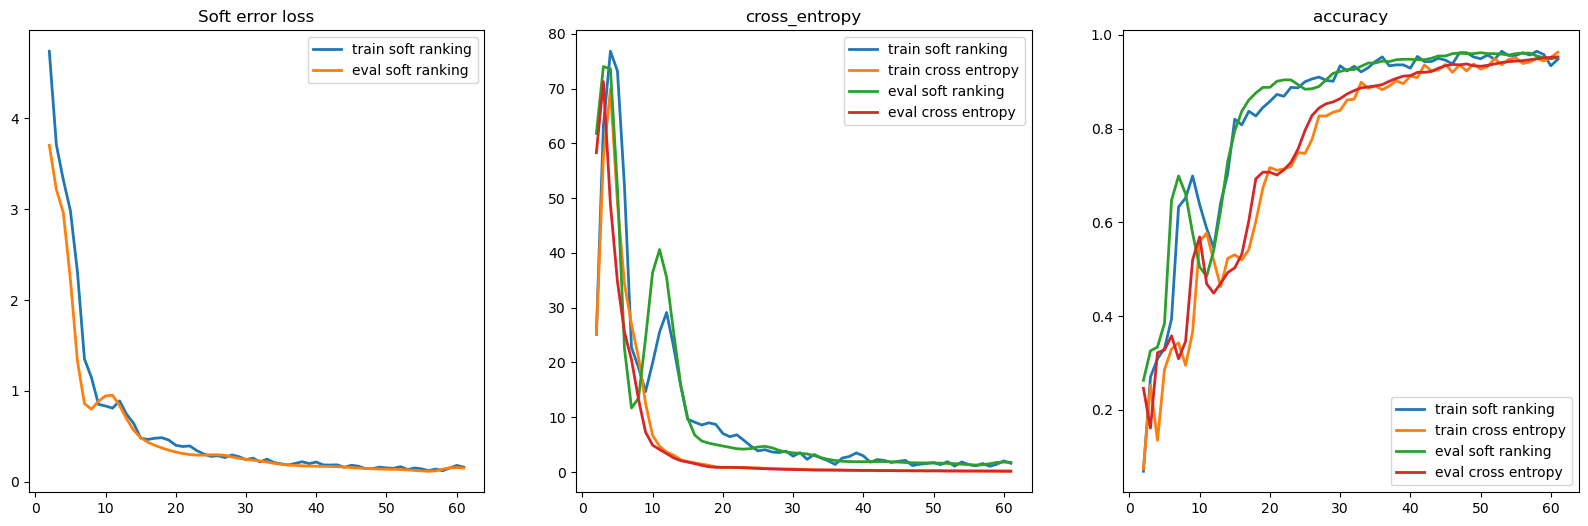

In [156]:
fix, axes = plt.subplots(1, 3, figsize=(20, 6))
for j, ds in enumerate(["train", "eval"]):
    for i, metric in enumerate(["loss", "cross_entropy", "accuracy"]):
        axes[i].set_title(metric)
        vals = results[ds + "_" + metric]
        x = np.array(list(map(lambda x: x[0], vals)))
        y = np.array(list(map(lambda x: x[1], vals)))
        axes[i].plot(x, y, label=ds + " soft ranking", linewidth=2.0)
        if metric != "loss":
            # Only plot the loss for the soft ranking training.
            vals = results_ce[ds + "_" + metric]
            x = np.array(list(map(lambda x: x[0], vals)))
            y = np.array(list(map(lambda x: x[1], vals)))
            axes[i].plot(x, y, label=ds + " cross entropy", linewidth=2.0)

        if j == 1:
            axes[i].legend()
axes[0].set_title("Soft error loss")